# Soccer Event Detection


## 1.Initial setup and data loading

### 1.1 Libraries installation and import

In [ ]:
# Import libraries for machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline
from PIL import Image


import os
import random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

# Import libraries for metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Import libraries for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, Rescaling, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, F1Score

# Import drive for accessing data stored in google drive
from google.colab import drive

# Import libraries for image manipulation
import cv2
import imghdr

### 1.2 Dataset download

In [ ]:
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/Information Retrieval/SoccerEventsDetection/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
!kaggle datasets download "federicopiscitelli/soccer-events-detection-test"
!kaggle datasets download "federicopiscitelli/soccer-events-detection-train"

 99% 946M/954M [00:11<00:00, 51.6MB/s]
100% 954M/954M [00:11<00:00, 88.7MB/s]
100% 8.65G/8.65G [01:42<00:00, 118MB/s] 
100% 8.65G/8.65G [01:42<00:00, 90.8MB/s]


In [ ]:
!unzip soccer-events-detection-test.zip > /dev/null
!unzip soccer-events-detection-train.zip > /dev/null

print("Unzipping datasets complete")

Unzipping datasets complete


### 1.3 Data cleaning

In [ ]:
train_folder = '/content/Train'
validation_folder = '/content/Test'

In [ ]:
img_accepted_extensions = ["png", "jpg", "jpeg", "bmp"]

In [ ]:
def filter_valid_images(directory):
  class_distributions = []
  for image_class in os.listdir(directory):
    print("Analyzing images in folder {}".format(os.path.join(directory, image_class)))
    count_class_elements = 0
    for image in os.listdir(os.path.join(directory, image_class)):
      image_path = os.path.join(directory, image_class, image)
      try:
        img = load_img(image_path)
        img_array = np.array(img)
        # Check if the image is truncated
        if img_array.nbytes < 75:
          print(f"Truncated image detected: {image_path}")
          os.remove(image_path)
        else:
          count_class_elements += 1
      except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        os.remove(image_path)
        continue
    class_distributions.append({image_class: count_class_elements})
  return class_distributions

**Preparing training data**

Using *filter_valid_images* function to delete from the train folder all the files that are not images.

In [ ]:
train_classes_distribution = filter_valid_images(train_folder)
train_data = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',  # Ensure labels are one-hot encoded
    image_size=(256, 256),     # Specify image size
    batch_size=32,             # Specify batch size
    validation_split=0.2,  # Split the dataset for validation
    subset='training',  # Use the training subset
    seed=4242
)

Analyzing images in folder /content/Train/Cards
Analyzing images in folder /content/Train/Penalty
Analyzing images in folder /content/Train/Tackle
Analyzing images in folder /content/Train/Free-Kick
Analyzing images in folder /content/Train/Yellow-Cards
Analyzing images in folder /content/Train/Corner
Analyzing images in folder /content/Train/Left
Analyzing images in folder /content/Train/To Subtitue
Error loading image /content/Train/To Subtitue/To Subtitue__21__14.jpg: cannot identify image file <_io.BytesIO object at 0x7c3aec4337e0>
Error loading image /content/Train/To Subtitue/To Subtitue__22__24.jpg: image file is truncated (75 bytes not processed)
Analyzing images in folder /content/Train/Red-Cards
Analyzing images in folder /content/Train/Right
Analyzing images in folder /content/Train/Center
Analyzing images in folder /content/Train/No-Soccer
Found 65998 files belonging to 12 classes.
Using 52799 files for training.


**Preparing validation data**

Using the same function as above to get rid of the non image files in the test folder.

In [ ]:
test_classes_distribution = filter_valid_images(validation_folder)
validation_data = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',  # Ensure labels are one-hot encoded
    image_size=(256, 256),     # Specify image size
    batch_size=32,              # Specify batch size)
    validation_split=0.2,
    subset='validation',  # Use the validation subset
    seed=4242
)

Analyzing images in folder /content/Test/Cards
Analyzing images in folder /content/Test/Penalty
Analyzing images in folder /content/Test/Tackle
Analyzing images in folder /content/Test/Free-Kick
Analyzing images in folder /content/Test/To-Subtitue
Analyzing images in folder /content/Test/Yellow-Cards
Analyzing images in folder /content/Test/Corner
Analyzing images in folder /content/Test/Left
Analyzing images in folder /content/Test/Red-Cards
Analyzing images in folder /content/Test/Right
Analyzing images in folder /content/Test/Center
Analyzing images in folder /content/Test/No-Soccer
Found 65998 files belonging to 12 classes.
Using 13199 files for validation.


### 1.4 Analyzing dataset distribution

Check what are the classes in the two dataset and get the number of valid files for each class.

In [ ]:
def make_bar_diagram(labels, values, dataset_type):
    plt.figure(figsize=(10, 4))
    plt.bar(labels, values)
    plt.xlabel('Class')
    plt.ylabel('Values')
    plt.title('Class distribution in {} dataset'.format(dataset_type))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

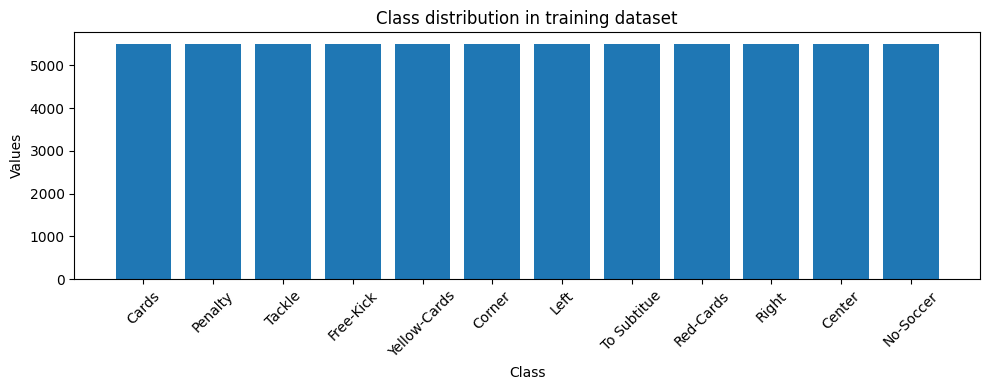

In [ ]:
labels = [list(item.keys())[0] for item in train_classes_distribution]
values = [list(item.values())[0] for item in train_classes_distribution]

make_bar_diagram(labels, values, 'training')

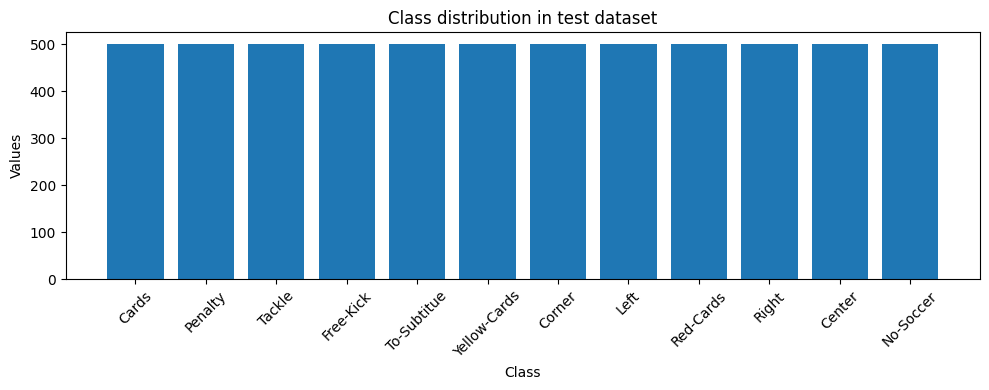

In [ ]:
labels = [list(item.keys())[0] for item in test_classes_distribution]
values = [list(item.values())[0] for item in test_classes_distribution]

make_bar_diagram(labels, values, 'test')

### 1.5 Training data samples

In [ ]:
train_data_iterator = train_data.as_numpy_iterator()
train_batch = train_data_iterator.next()

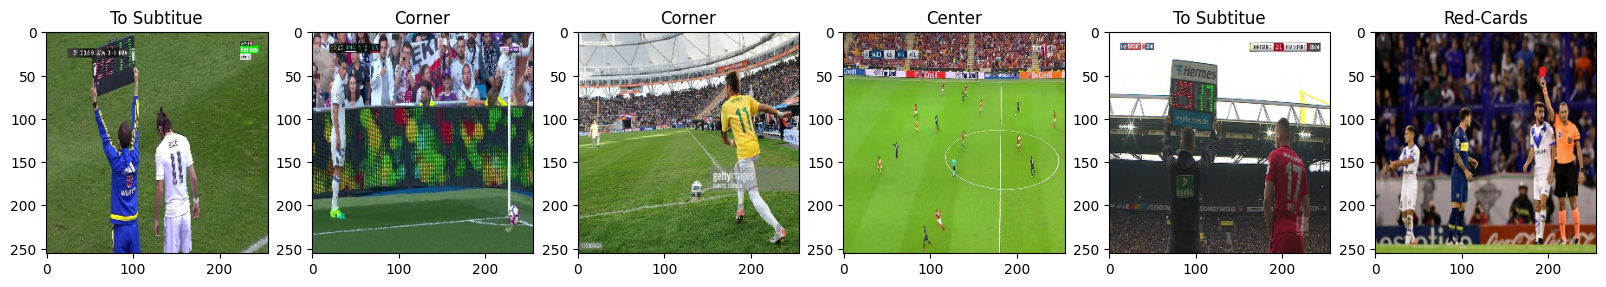

In [ ]:
train_class_names = train_data.class_names
num_classes = len(train_class_names)
train_labels = np.argmax(train_batch[1], axis=1)  # Convert one-hot encoded labels to class indices
train_class_labels = [train_class_names[label] for label in train_labels]  # Convert class indices to class names

# Plot images with corresponding labels
fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(train_class_labels[idx])  # Set the title with the class name
plt.show()

## 2.Pre-processing data

For the pre-processing phase I added a pre-processing layer in the layers of the model

In [ ]:
# Define the data augmentation layers
preprocessing_layers = Sequential([
    Rescaling(scale=1./255),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomRotation((-0.2,0.2))
])

## 3.Deep Model

### 3.1 Building the model

In [ ]:
model = Sequential()

In [ ]:
input_shape = (256, 256, 3)

# building a linear stack of layers with the sequential model
"""
model = Sequential([
    preprocessing_layers,

    Conv2D(128, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu',padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])
"""

model = Sequential()
model.add(preprocessing_layers)
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.build(input_shape=(32,256,256,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 246016)             

### 3.2 Defining callbacks

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Metric to monitor (e.g., validation loss)
    patience=6,           # Number of epochs with no improvement before stopping
    min_delta=0.001,      # Minimum change in the monitored quantity to qualify as improvement
    mode='auto',          # Direction of improvement (e.g., 'min' for loss, 'max' for accuracy)
    verbose=1             # Verbosity mode (0 = silent, 1 = progress bar)
)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',  # Filepath to save the model weights
    monitor='val_accuracy',    # Metric to monitor (e.g., validation accuracy)
    save_best_only=True,       # Save only the best model (based on the monitored metric)
    mode='auto',               # Direction of improvement (e.g., 'max' for accuracy)
    verbose=1                  # Verbosity mode (0 = silent, 1 = progress bar)
)

### 3.3 Train the model

In [ ]:
epochs = 20
history = model.fit(train_data, epochs=epochs, validation_data=validation_data,
                    verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

Epoch 1/20
1650/1650 [==============================] - ETA: 0s - loss: 1.9107 - accuracy: 0.2851
Epoch 1: val_accuracy improved from -inf to 0.41730, saving model to best_model.h5
1650/1650 [==============================] - 458s 271ms/step - loss: 1.9107 - accuracy: 0.2851 - val_loss: 1.5558 - val_accuracy: 0.4173 - lr: 0.0010
Epoch 2/20
1650/1650 [==============================] - ETA: 0s - loss: 1.6547 - accuracy: 0.3669
Epoch 2: val_accuracy improved from 0.41730 to 0.48519, saving model to best_model.h5
1650/1650 [==============================] - 444s 268ms/step - loss: 1.6547 - accuracy: 0.3669 - val_loss: 1.3792 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 3/20
1650/1650 [==============================] - ETA: 0s - loss: 1.5620 - accuracy: 0.3982
Epoch 3: val_accuracy improved from 0.48519 to 0.48966, saving model to best_model.h5
1650/1650 [==============================] - 435s 263ms/step - loss: 1.5620 - accuracy: 0.3982 - val_loss: 1.3269 - val_accuracy: 0.4897 - lr: 0.0010
E

### 3.4 Printing loss and accuracy

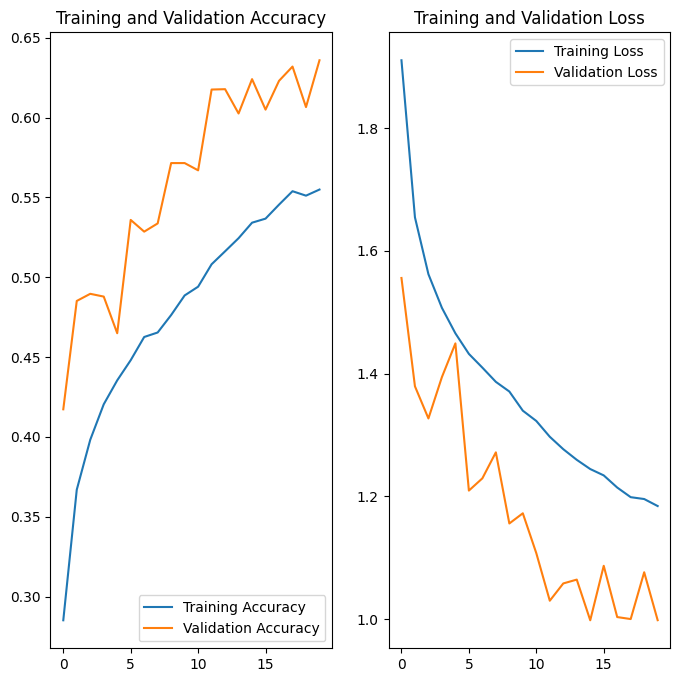

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4.Evaluate performances

In [ ]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [ ]:
true_labels = []
predicted_labels = []
predicted_scores = []

#model = tf.keras.models.load_model('best_model.h5')

test_data_iterator = validation_data.as_numpy_iterator()
for batch in test_data_iterator:
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

  # Convert one-hot encoded predictions to class labels
  predicted_classes = np.argmax(yhat, axis=1)
  true_classes = np.argmax(y, axis=1)

  # Append true and predicted labels to the lists
  true_labels.extend(true_classes)
  predicted_labels.extend(predicted_classes)

  predicted_scores.extend(yhat)

1/1 [==============================] - 0s 87ms/step


### 4.1 Precision, Recall, Accuracy, F1 Score

In [ ]:
# Calculate F1 score
f1_result = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')
print("F1 Score:", f1_result)

Precision: 0.815625011920929
Recall: 0.47458142042160034
Accuracy: 0.6359572410583496
F1 Score: 0.628619716482999


### 4.2 Confusion Matrix

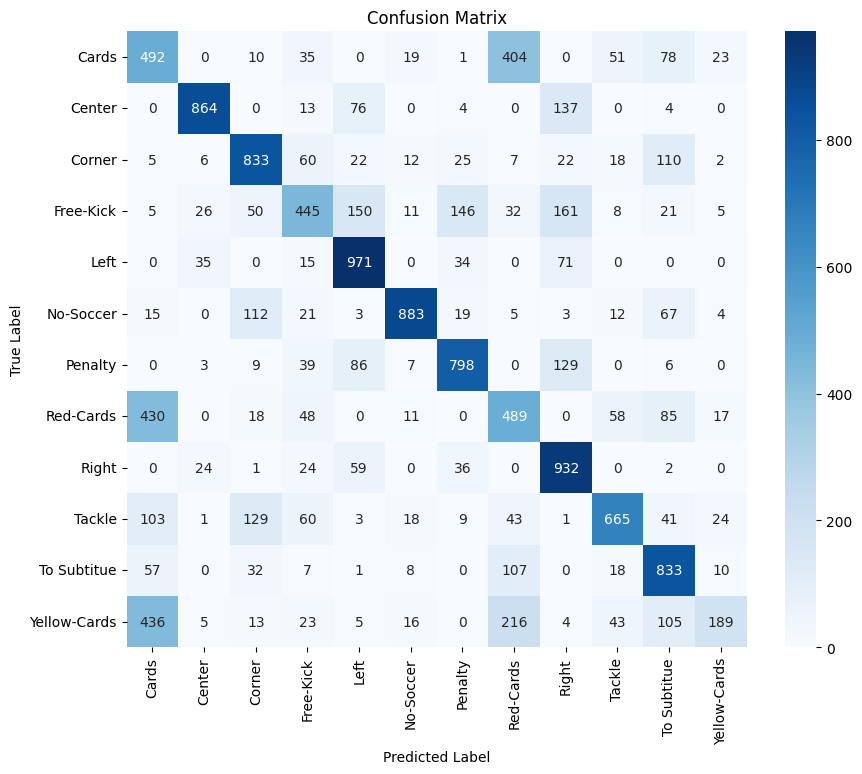

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_data.class_names, yticklabels=validation_data.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predicted_scores[0]

array([2.6119824e-09, 8.6446526e-03, 1.4973551e-04, 3.7258840e-01,
       1.4189679e-02, 6.3948227e-07, 5.7988298e-01, 4.8523345e-09,
       2.4531074e-02, 3.3817287e-06, 5.9526342e-06, 3.4696779e-06],
      dtype=float32)

In [ ]:
# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Get class names
classes = train_data.class_names

# Create an empty DataFrame
metrics_df = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1-score', 'Support'])

# Iterate over classes to add metrics
for i, class_name in enumerate(classes):
    metrics_df = metrics_df.append({'Class': class_name,
                                    'Precision': precision[i],
                                    'Recall': recall[i],
                                    'F1-score': f1_score[i],
                                    'Support': support[i]}, ignore_index=True)

# Print the DataFrame
metrics_df

,Class,Precision,Recall,F1-score,Support
0,Cards,0.318859,0.442049,0.370482,1113
1,Center,0.896266,0.786885,0.838021,1098
2,Corner,0.690141,0.742424,0.715328,1122
3,Free-Kick,0.563291,0.419811,0.481081,1060
4,Left,0.705669,0.862345,0.776179,1126
5,No-Soccer,0.896447,0.771853,0.829497,1144
6,Penalty,0.744403,0.740947,0.742671,1077
7,Red-Cards,0.375288,0.423010,0.397723,1156
8,Right,0.638356,0.864564,0.734437,1078
9,Tackle,0.761741,0.606199,0.675127,1097


## 5.Predictions on new images


In [ ]:
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    if not image_files:
        print("No image files found in the folder.")
        return None
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(folder_path, random_image_file)

    return random_image_path

1/1 [==============================] - 0s 22ms/step


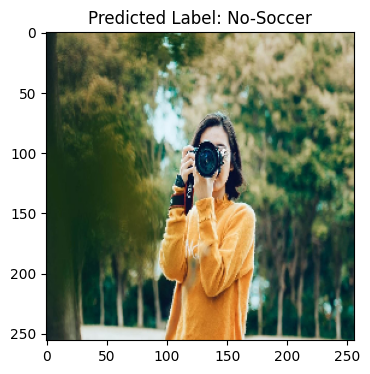

In [ ]:
image_path = get_random_image("/content/drive/MyDrive/Colab Notebooks/Information Retrieval/SoccerEventsDetection/predictions")
img = tf.keras.utils.load_img(image_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Predict the image label and score

predictions = model.predict(img_array)
predicted_label = np.argmax(predictions)
score = tf.nn.softmax(predictions[0])

# Get the class names from the dataset
class_names = train_data.class_names

# Plot the image
plt.figure(figsize=(4, 4))
plt.imshow(img_array[0] / 255.0)  # Normalize pixel values to [0, 1]

# Print the predicted label and score
plt.title(f'Predicted Label: {class_names[predicted_label]}')
plt.show()